## Exploring the data

In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv", index_col=0)
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [2]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()

# look at the # of missing points in each column
missing_values_count[0:3]

Murder      0
Assault     0
UrbanPop    0
dtype: int64

In [3]:
#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


From our data we can see that our means range from 7.79 all the way to 170.76 which displays 
the clear need to scale our data in order to  look at certain inferances in the data.

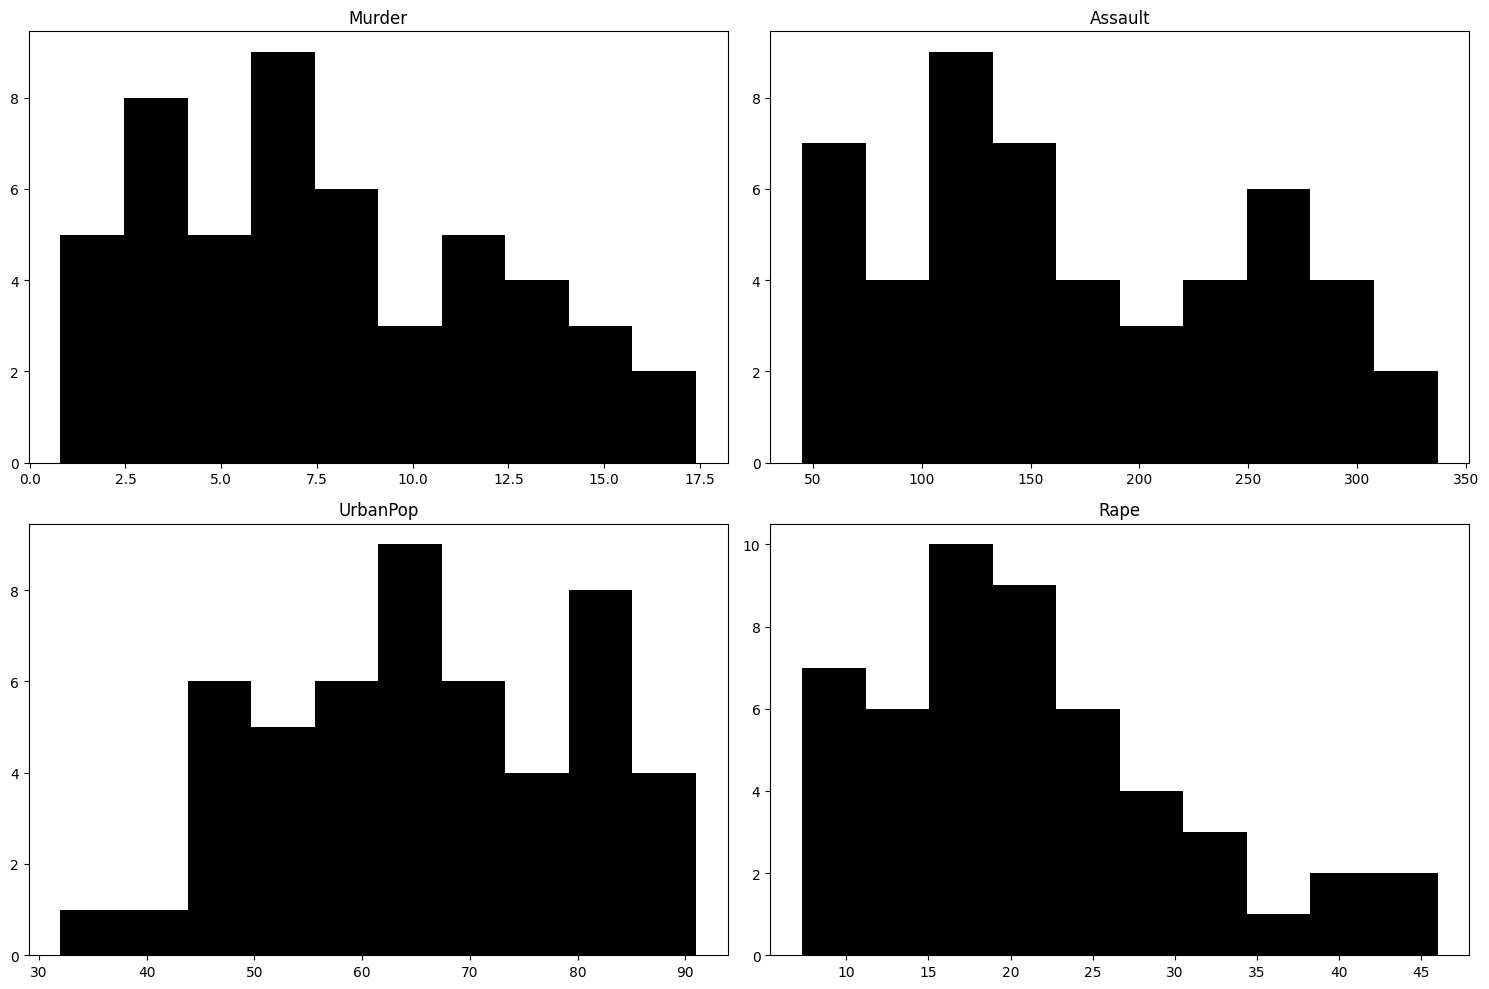

In [4]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

In [5]:
corr_df = df.corr()
labels =corr_df.columns

correlations = corr_df.corr()

<Axes: >

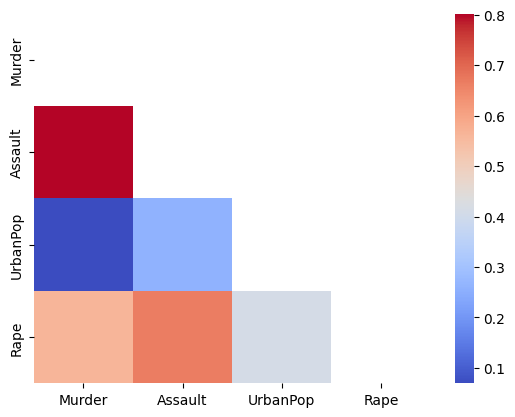

In [6]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

We can see here that there is a strong relationship between murder and assault which 
points to the fact that solving the assualt numbers in given state will aid in decreasing 
the murder rate. This is the strongest correlation that we can see on this heatmap, whereas
the urban population and the murder rate which indicates that it is safer to live in a city
than in a more rural enviroment.


In [7]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,-11.448007,-2.494933,2.407901
1,92.827450,-17.982943,20.126575,-4.094047
2,124.068216,8.830403,-1.687448,-4.353685
3,18.340035,-16.703911,0.210189,-0.520994
4,107.422953,22.520070,6.745873,-2.811826


In [8]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [9]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [10]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [11]:
cities = df.index
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()


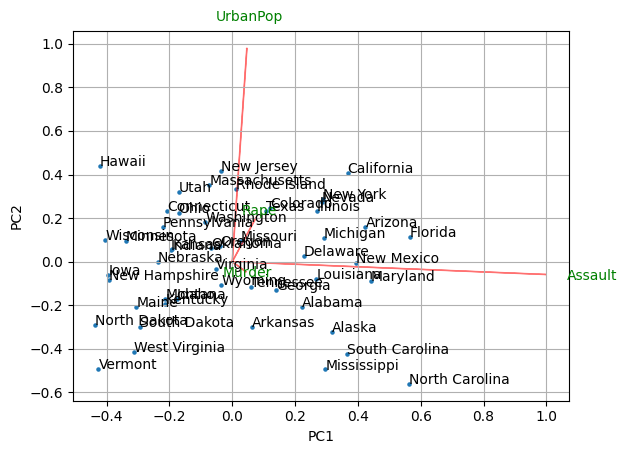

In [12]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels), list(cities))
plt.show()

From this plot we see that Assualt and urban population have a larger level
of importance when it comes to the distribution or the variance of our data. This 
however may have to do with the fact that our data has not yet been scaled. As these 
features recorded the highest mean data. We will come look to verify this statement by having a
look at the feature importance.

In [13]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


As we can see from these results that the initial statement was indeed true. Now in order to offset 
these features we are going standardize our data.

In [14]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,-1.133,-0.444,-0.156
1,1.950,-1.073,2.040,0.439
2,1.763,0.746,0.055,0.835
3,-0.141,-1.120,0.115,0.183
4,2.524,1.543,0.599,0.342


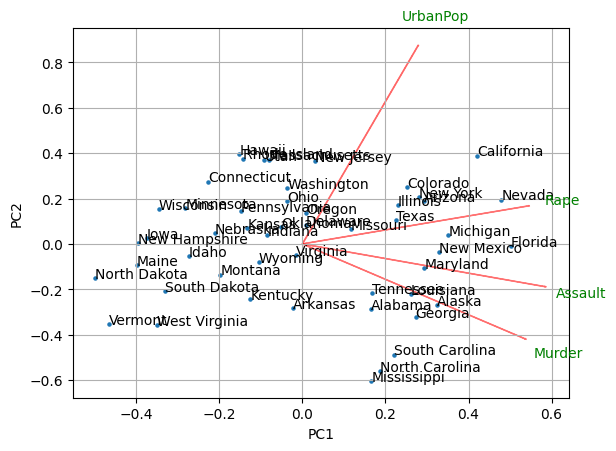

In [15]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

In [17]:
# Feature importance
pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


From this we that urban assualt and urban population still play the most important 
roles in understanding the distribution of this data.

Text(0.5, 1.0, 'Cumulative Explained Variance')

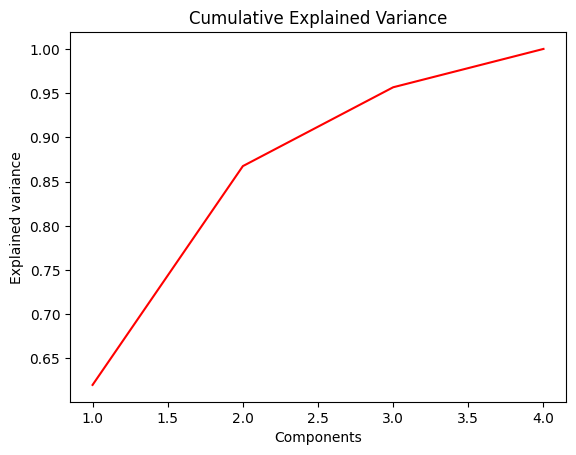

In [18]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

This graph shows us that the first two components of our PCA explains about 85% of our 
data distrfibution. And 3 explaining 90% of the variance.

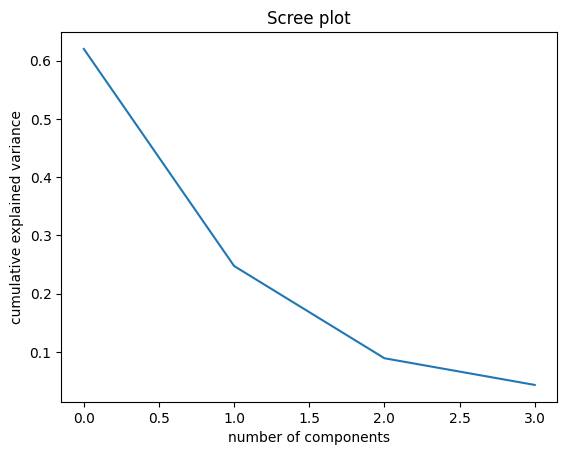

In [19]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

Due to the fact that 3 components explain about 95% of the variance that we have in the data we will 
then use this as the number of variables and the variables that we use as this simplifies our data quite 
significantly.

In [24]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
City,,,
Alabama,0.986,-1.133,-0.444
Alaska,1.950,-1.073,2.040
Arizona,1.763,0.746,0.055
Arkansas,-0.141,-1.120,0.115
California,2.524,1.543,0.599


## Hierarchical clustering

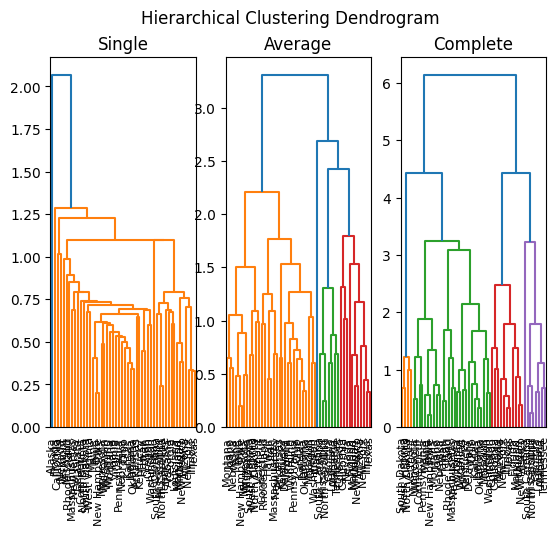

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

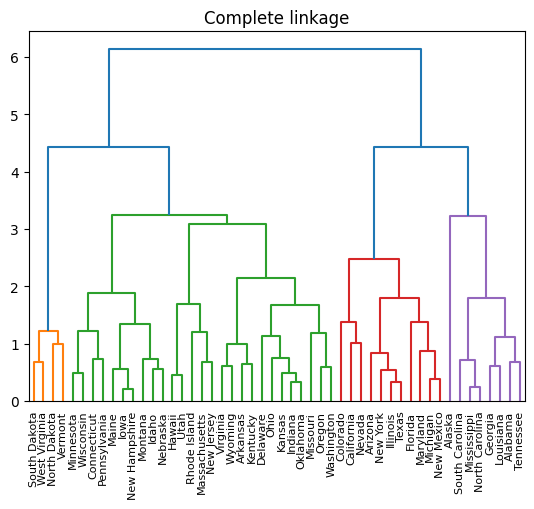

In [26]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

From doing our Hierarchical clustering we can clearly see that the optimal number of 
clusters for our dataset is 4 clusters. We will then explore this further by doing a
K-means clustering to further analyse the clusters. 

## K-means clustering

C:\Users\mphon\AppData\Local\Temp\ipykernel_18692\421620698.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


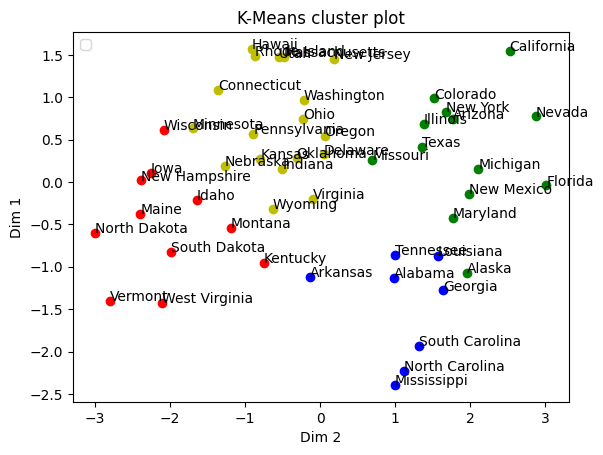

In [27]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

We can see from this cluster plot that for our blue cluster we see that there is mainly 
states that would be labeled as conservative, whereas the green cluter we see states that
are mainly traditionly democrate states. These are our most clearly defined clusters 
and the rest have mixture of states that are not as easy to point out any residing 
patterns within the data itselt.